### Preliminary
* get model (trained) and test it
* graph the result
* This uses the difference between days to establish the data (and loss)
* reads json file in
* The training figures were stored in Offline6
* The data is log(x+1) transformed

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
import subprocess
import seaborn as sns
import json
import math

#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [2]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

84
(172, 5)
(172, 5)
(172, 74)


In [3]:
def find_zero(lst):
    numzero = 0
    for i in lst:
        if i ==0:
            numzero += 1
    return(numzero)

# graph number of days zero
cutoff = 25 # at most = 0
lstzero = []
skip_countries = []
for i in range(len(countries)):
    numz = find_zero(casesA[i,:].tolist())
    lstzero.append(numz)
    if numz > cutoff:
        skip_countries.append(i)

#sns.distplot(np.array(lstzero));

In [4]:
len(skip_countries)

149

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
pred_days = test_d
# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return y_pred.view(-1)

    


In [6]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred, y)
            test_loss += loss.item() 
            
    return pred,test_loss




In [7]:
countries

['Burundi',
 'Djibouti',
 'Eritrea',
 'Ethiopia',
 'Kenya',
 'Madagascar',
 'Malawi',
 'Mauritius',
 'Mozambique',
 'Rwanda',
 'Seychelles',
 'Somalia',
 'South Sudan',
 'Uganda',
 'Tanzania',
 'Zambia',
 'Zimbabwe',
 'Angola',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Equatorial Guinea',
 'Gabon',
 'Sao Tome and Principe',
 'Botswana',
 'Eswatini',
 'Namibia',
 'South Africa',
 'Benin',
 'Burkina Faso',
 'Cabo Verde',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Liberia',
 'Mali',
 'Mauritania',
 'Niger',
 'Nigeria',
 'Senegal',
 'Sierra Leone',
 'Togo',
 'Algeria',
 'Egypt',
 'Libya',
 'Morocco',
 'Sudan',
 'Tunisia',
 'Western Sahara',
 'Armenia',
 'Azerbaijan',
 'Bahrain',
 'Cyprus',
 'Georgia',
 'Iraq',
 'Israel',
 'Jordan',
 'Kuwait',
 'Lebanon',
 'Oman',
 'Qatar',
 'Saudi Arabia',
 'Syria',
 'Turkey',
 'United Arab Emirates',
 'Yemen',
 'Kazakhstan',
 'Kyrgyzstan',
 'Uzbekistan',
 'Afghanistan',
 'Bangladesh',
 'Bhutan',
 'India',
 'Iran',
 'Maldives',
 'Nepal'

In [8]:
import matplotlib.pyplot as plt

def graph_country(index,prediction,outdir):
    print(index)
    print(countries[index])
    
    # produce projection closeup & general graph
    # with label & title
    #print(prediction)
    newpred = prediction#.tolist()
    
    # general trend
    x = np.linspace(1, len(casesA[index,:].tolist()), len(casesA[index,:].tolist()))
    y_real = casesA[index,:]
    y_pred = casesA[index,:days-test_d].tolist()
    #print(len(y_pred))
    y_pred.extend(newpred)
    #print(len(y_pred))
    #print(len(y_real))
    y_pred = np.array(y_pred)
    
    # 
    plt.figure(index)
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 
    #
    plt.plot(x, y_real,':', label = "Real",color = "crimson")
    plt.plot(x, y_pred, label = "Prediction", color = "teal")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" trend")
    
    plt.legend(frameon=False)
    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    ax.axvspan(x[-test_d-1], x[-1],color = "coral",alpha = 0.3)
    
    plt.savefig(outdir+countries[index]+"_general",dpi=300)
    
    plt.show()
    # specific plot
    x = np.linspace(1, len(casesA[index,days-test_d:].tolist()), len(casesA[index,days-test_d:].tolist()))
    y_real = casesA[index,days-test_d:]
    y_pred = newpred
    plt.figure(index*2)
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 

    plt.plot(x, y_real,':', label = "Real",color = "crimson")
    plt.plot(x, y_pred, label = "Prediction", color = "teal")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" 5 days prediction")
    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()
    plt.legend(frameon=False)
    
    plt.savefig(outdir+countries[index]+"_specific",dpi=300)    
    plt.show()

In [23]:

b = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16819754465224315, 0.16819754465224315, 0.25229631697836474, 0.25229631697836474, 0.25229631697836474]
print(len(b))
print(b)
print(len(b))

b[-3]
math.sqrt(4)

74
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16819754465224315, 0.16819754465224315, 0.25229631697836474, 0.25229631697836474, 0.25229631697836474]
74


2.0

In [10]:

import json
with open("./country_summary_9.js",'r') as outfile:
    dt = json.load(outfile)

In [11]:
test_d

5

In [12]:
def chain_val(start,array):
    lst = array.tolist()
    newlst = []
    for i in range(len(lst)):
        if i == 0:
            newlst.append(lst[i]+start)
            continue
        newlst.append(newlst[i-1] + lst[i])
    return(newlst)

chain_val(1,np.array([2,3,4]))

[3, 6, 10]

In [13]:
{"*Taiwan":0,"US":0,"Italy":0, "Korea, South":0,"Germany":0,"Japan":0}

{'*Taiwan': 0,
 'US': 0,
 'Italy': 0,
 'Korea, South': 0,
 'Germany': 0,
 'Japan': 0}

Directory ./graph_offline9/ exists
[5.113183498382568, 4.61324405670166, 4.864111423492432, 4.658010482788086, 4.584681510925293]
163
Belgium


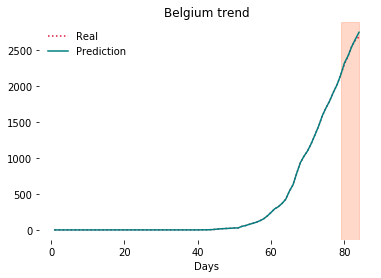

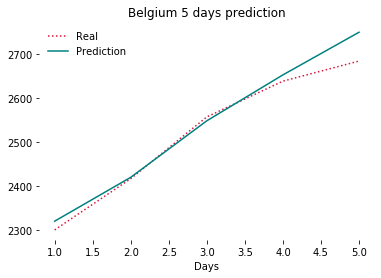

[2320.83442553 2420.64508076 2549.200848   2653.62697427 2750.59895344] [2300.93825337 2417.50808051 2558.0648891  2639.3445169  2685.07509306]
Belgium
996.3269059990253
[0.0, 0.0, 0.11426758766174316, 0.11568283289670944, 0.11888323724269867]
84
Cambodia


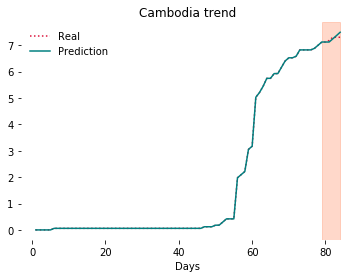

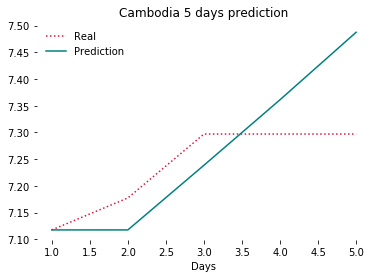

[7.11766335 7.11766335 7.23871541 7.36135516 7.48759357] [7.11766335 7.17747565 7.29710024 7.29710024 7.29710024]
Cambodia
0.009480540783198663
[0.0, 0.0, 0.10348998010158539, 0.0, 0.0]
170
Diamond Princess


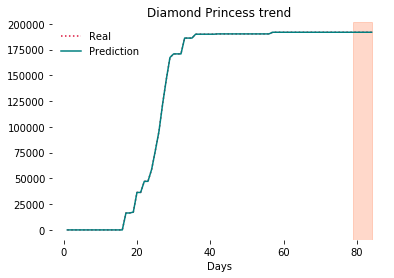

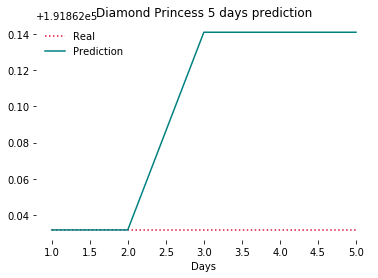

[191862.03179736 191862.03179736 191862.14083204 191862.14083204
 191862.14083204] [191862.03179736 191862.03179736 191862.03179736 191862.03179736
 191862.03179736]
Diamond Princess
0.0071331369842838
[0.8403977155685425, 1.0351834297180176, 1.1747207641601562, 1.0208156108856201, 1.27508544921875]
44
Egypt


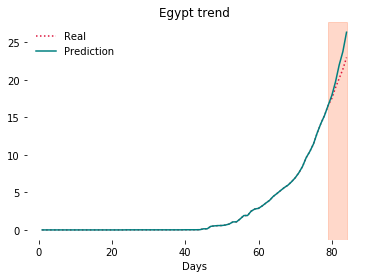

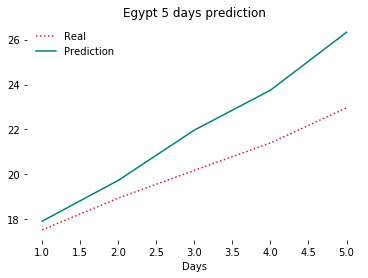

[17.91972122 19.73534388 21.97258275 23.74804028 26.3270475 ] [17.53076189 18.94768524 20.17894276 21.4004284  22.96393002]
Egypt
4.162136127924919
[3.1873793601989746, 2.7876381874084473, 3.3045077323913574, 2.75347638130188, 2.7858402729034424]
140
Finland


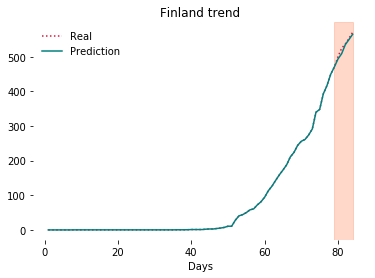

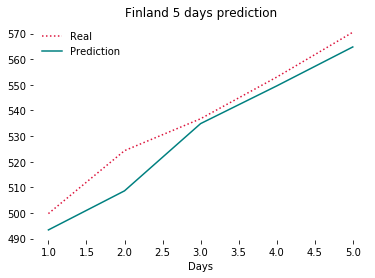

[493.38036281 508.62297527 534.85810658 549.55521285 564.76864872] [499.75454454 524.30009096 536.75334614 552.99672245 570.50347247]
Finland
66.94525479257962
[4.14251708984375, 4.09526252746582, 3.9879443645477295, 4.022468090057373, 3.971859931945801]
164
Germany


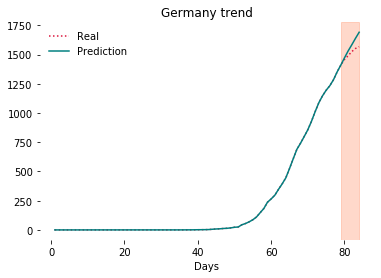

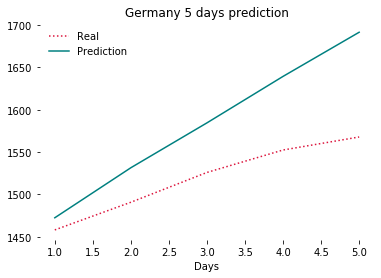

[1472.50572193 1531.56082513 1584.50471148 1639.34346244 1691.4266326 ] [1458.16710718 1490.83446173 1525.99632746 1552.46917817 1567.83011543]
Germany
5622.140774606794
[0.2821250557899475, 0.15346874296665192, 0.0, 0.2578394114971161, 0.3111613094806671]
73
India


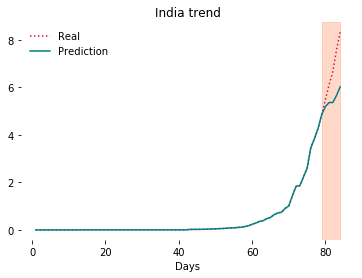

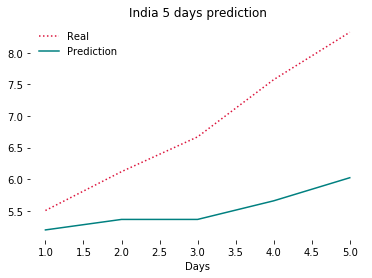

[5.19911743 5.36498877 5.36498877 5.65911975 6.02412915] [5.50577959 6.12027039 6.67026864 7.57461359 8.32388656]
India
2.265249659579026
[4.9418511390686035, 4.804925441741943, 5.428323268890381, 4.632096290588379, 4.48707914352417]
153
Italy


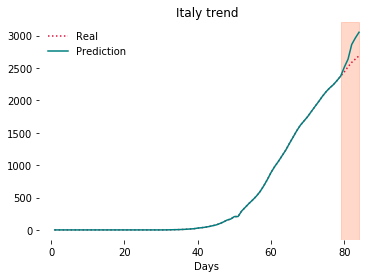

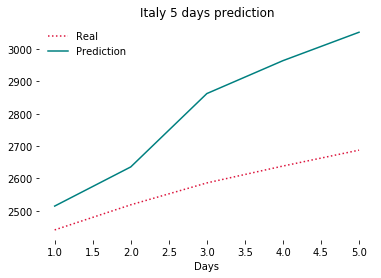

[2514.51140773 2635.62179408 2862.3888151  2964.11800388 3051.9795186 ] [2440.82919753 2518.46495549 2586.14401847 2638.29262197 2687.44760124]
Italy
66902.33577277433
[0.0, 0.944923996925354, 1.5340876579284668, 1.7280840873718262, 1.4988185167312622]
81
Japan


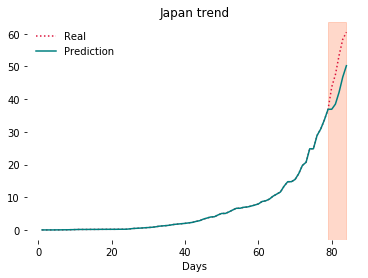

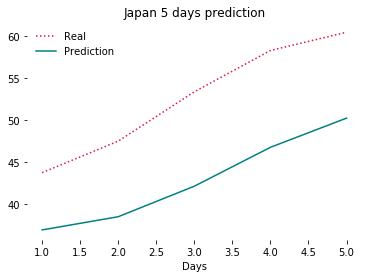

[36.90014727 38.47276511 42.1098581  46.73971535 50.21611251] [43.7235514  47.47919099 53.35380196 58.27171317 60.44603083]
Japan
98.34780544780803
[1.6842386722564697, 1.7451276779174805, 1.7083933353424072, 1.6604565382003784, 1.5858672857284546]
80
Korea, South


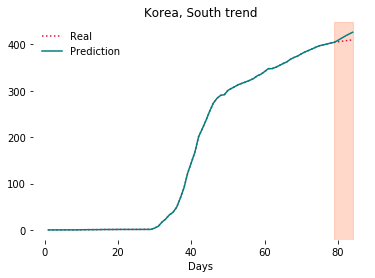

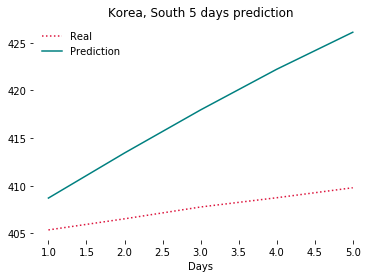

[408.71251707 413.43914966 417.95923509 422.22094755 426.10447251] [405.37154144 406.5352875  407.77661662 408.74640499 409.79377644]
Korea, South
122.02265063735445
[2.0473861694335938, 2.005363702774048, 1.8546628952026367, 1.824449062347412, 1.8159079551696777]
87
Malaysia


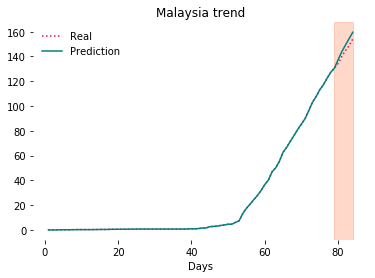

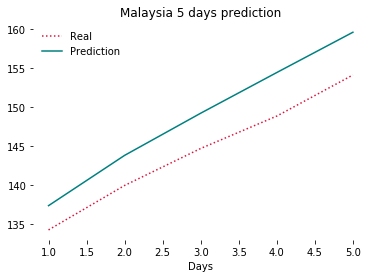

[137.37853262 143.8073279  149.19687184 154.39625045 159.54290498] [134.27671013 139.96168819 144.68887104 148.82901811 154.08144349]
Malaysia
21.1107912635129
[0.0, 0.0, 0.0, 0.0, 0.0]
76
Nepal


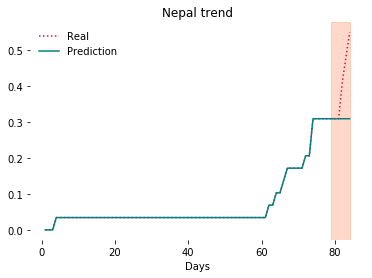

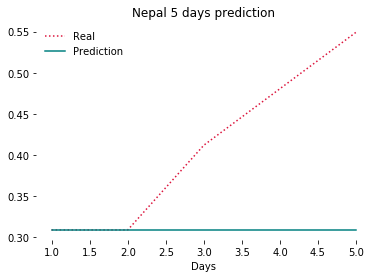

[0.30888762 0.30888762 0.30888762 0.30888762 0.30888762] [0.30888762 0.30888762 0.41185016 0.48049186 0.54913355]
Nepal
0.01955348101919783
[1.0717207193374634, 0.7536769509315491, 1.4552216529846191, 0.955906867980957, 0.7568027377128601]
88
Philippines


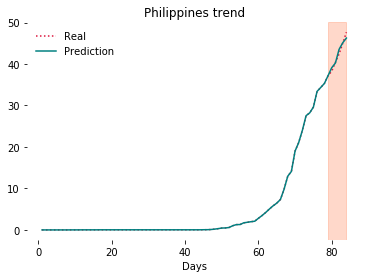

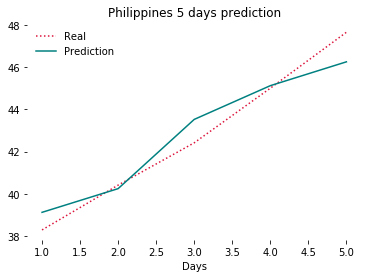

[39.11659909 40.24139754 43.52683078 45.12785908 46.25930959] [38.28215251 40.40843178 42.41607745 45.00776548 47.66333315]
Philippines
0.7887358272089708
[1.8990370035171509, 2.0031895637512207, 2.1109793186187744, 2.255105495452881, 2.4279818534851074]
136
Russia


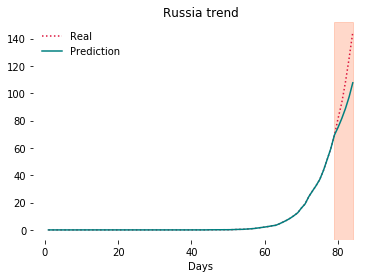

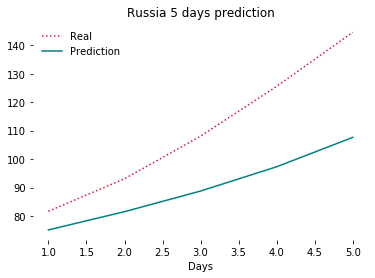

[ 75.10103364  81.51369523  88.77001813  97.30631742 107.64229873] [ 81.65994516  93.08288118 108.0622082  125.59062472 144.59915773]
Russia
542.9730897902318
[2.4223079681396484, 2.2221298217773438, 2.4702632427215576, 2.5982818603515625, 2.529282569885254]
89
Singapore


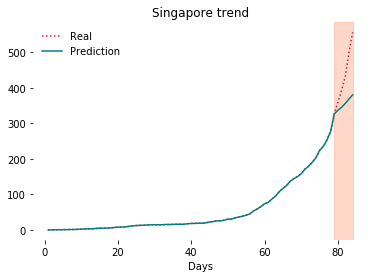

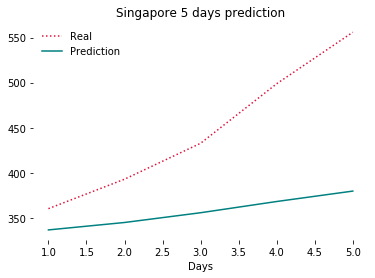

[336.74859615 344.97555789 355.80111732 368.24174264 379.78624574] [360.32093861 392.96861379 432.7953589  498.7744302  555.86512921]
Singapore
11365.931540895468
[4.954869270324707, 4.686855316162109, 4.706308364868164, 4.603416442871094, 4.62507963180542]
161
Spain


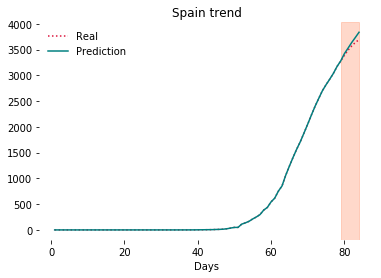

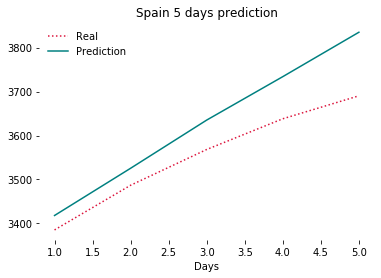

[3418.00492064 3525.51632927 3635.15928091 3733.98406029 3834.99495636] [3385.17259626 3486.85203951 3568.21270467 3638.10930134 3690.33925515]
Spain
7434.394838891667
[0.21911996603012085, 0.0, 0.1895388811826706, 0.23099052906036377, 0.0]
78
Sri Lanka


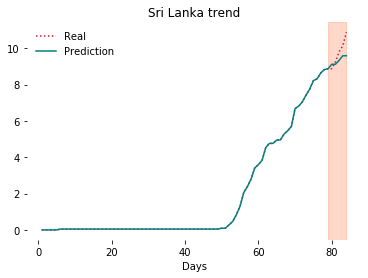

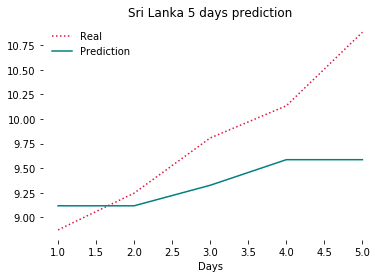

[9.11799149 9.11799149 9.32668361 9.58653092 9.58653092] [ 8.87301087  9.24661133  9.80701201 10.13391241 10.88111333]
Sri Lanka
0.4565688124392726
[4.033297538757324, 3.5524704456329346, 3.762674570083618, 3.7151379585266113, 4.1829304695129395]
146
Sweden


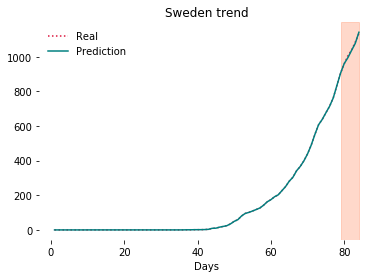

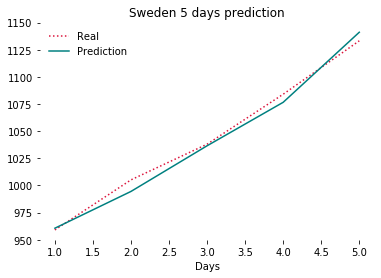

[ 960.56166415  994.46109237 1036.52454067 1076.58879253 1141.14647933] [ 958.98020352 1005.12215239 1037.99581554 1084.03874736 1133.25022502]
Sweden
47.235305471481084
[0.4271497130393982, 0.47917601466178894, 0.0, 0.4785631000995636, 0.40015488862991333]
79
Taiwan*


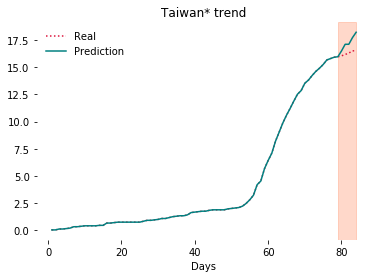

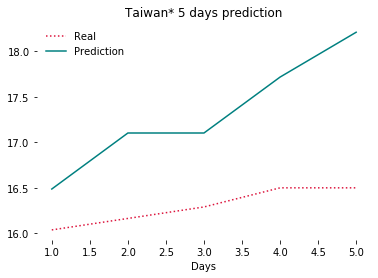

[16.48801965 17.10276298 17.10276298 17.71651691 18.20857269] [16.03911192 16.16507353 16.29103514 16.50097116 16.50097116]
Taiwan*
1.2266272336764152
[0.6693876385688782, 0.8497981429100037, 0.6104446649551392, 0.2743370831012726, 0.5147375464439392]
90
Thailand


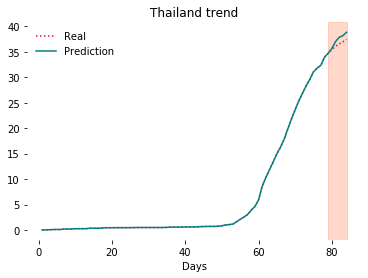

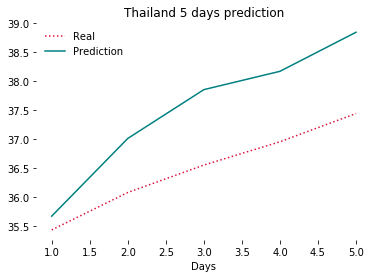

[35.66651798 37.00569261 37.84694256 38.16260078 38.83580008] [35.42980958 36.0745089  36.54728841 36.94843466 37.43554081]
Thailand
1.209432056710519
[4.448480129241943, 4.521427154541016, 4.631914138793945, 4.638379096984863, 4.660768508911133]
169
US


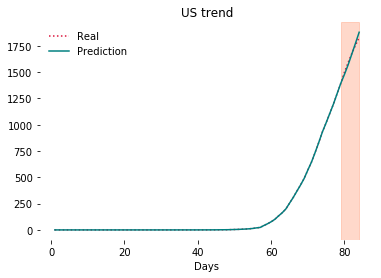

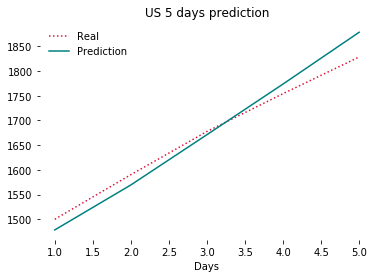

[1478.55522648 1569.52198162 1671.23245979 1773.60910798 1878.32640361] [1500.09373037 1590.30750962 1677.66934796 1754.12190809 1828.36300555]
US
762.6941917882142
[3.2052035331726074, 3.656425952911377, 3.6340866088867188, 3.5905532836914062, 3.6981539726257324]
65
United Arab Emirates


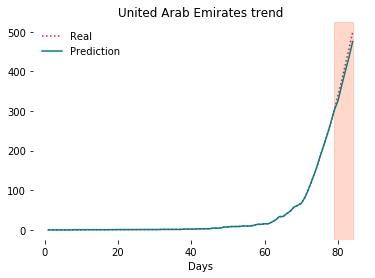

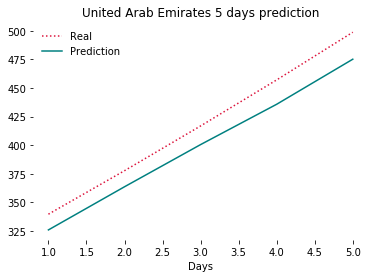

[325.9738731  363.69657161 400.5638211  435.8179503  475.1906567 ] [339.72336811 377.74003074 416.86888296 457.10992478 498.76648063]
United Arab Emirates
332.2580100584388
[0.0, 0.05382653698325157, 0.05191074684262276, 0.04874568432569504, 0.04765109345316887]
92
Vietnam


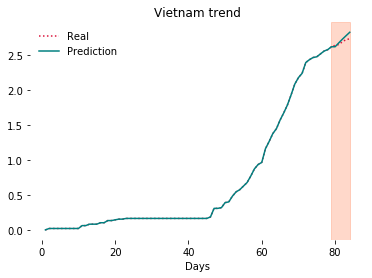

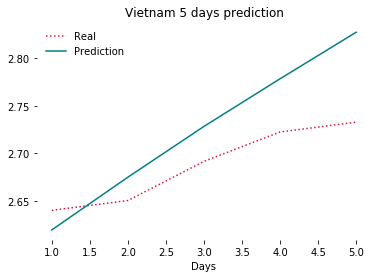

[2.6197218  2.67502333 2.72830506 2.77825836 2.82706301] [2.64026864 2.65054206 2.69163573 2.72245599 2.73272941]
Vietnam
0.00287577574773393


In [24]:
len(dt)

lr_dict=dict()
layerLst = []
stateLst = []
momentumLst = []
mseLst = []
nloss = []

keyCountry = {"*Taiwan":0,"US":0,"Italy":0, "Korea, South":0,"Germany":0,"Japan":0}

country_result = dict()
graph_dir = "./graph_offline9/"
directory = os.path.dirname(graph_dir)
if not os.path.exists(directory):
    print("Creating directory %s" % graph_dir)
    os.makedirs(directory)
else:
     print("Directory %s exists" % graph_dir)

for key,item in dt.items():
    # [hyperparam, [prediction, truth], error]
    # [lr, layer, state, momentum]111
    ind = countries.index(key)
    
    # hyper-param
    if item[0][0] in lr_dict:
        lr_dict[item[0][0]] += 1
    else:
        lr_dict[item[0][0]] = 1
    layerLst.append(item[0][1])
    stateLst.append(item[0][2])
    momentumLst.append(item[0][3])
    
    
    # get original
    print(item[1][0])
    startv = casesA[ind,-test_d-1]
    pred = chain_val(startv,np.exp(np.array(item[1][0]))-1)
    y = chain_val(startv,np.exp(np.array(item[1][1]))-1)
    
    # graph
    graph_country(ind,pred,graph_dir)
    
    # mse calculation
    a = np.array(pred)
    b = np.array(y)
    print(a,b)
    mse = ((a-b)**2).mean()
    print(key)
    print(str(mse))
    keyCountry[key] = math.sqrt(mse)
    mseLst.append(mse)
    nloss.append(mse/max(y))

### Show result:
* distribution of the hyper-parameter
* MSE distribution (histogram)
* MSE normalized to max of value (histogram)

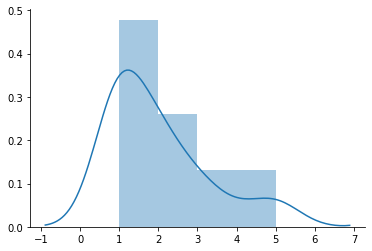

In [31]:
sns.distplot(np.array(layerLst))
sns.despine()
plt.show()


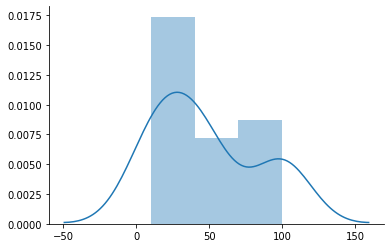

In [32]:
sns.distplot(np.array(stateLst))
sns.despine()
plt.show()


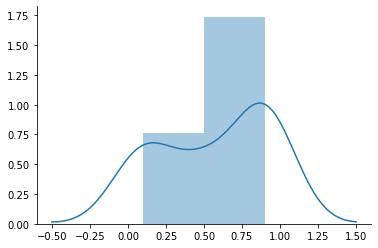

In [27]:
sns.distplot(np.array(momentumLst))
sns.despine()
plt.show()


In [28]:
math.sqrt(np.array(mseLst))

TypeError: only size-1 arrays can be converted to Python scalars

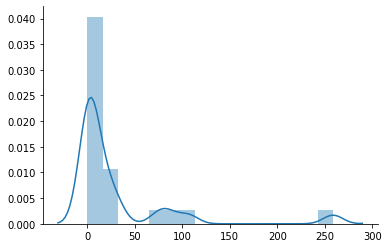

In [29]:
sns.distplot(np.sqrt(np.array(mseLst)))
sns.despine()
plt.show()

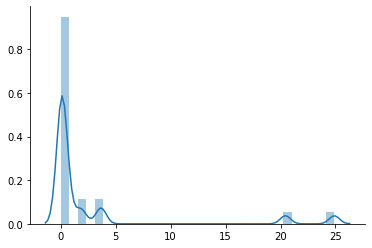

In [19]:

sns.distplot(np.array(nloss))
sns.despine()
plt.show()

In [30]:
keyCountry

{'*Taiwan': 0,
 'US': 27.616918578802636,
 'Italy': 258.6548583977775,
 'Korea, South': 11.046386315775601,
 'Germany': 74.98093607449026,
 'Japan': 9.917046205791724,
 'Belgium': 31.564646457691005,
 'Cambodia': 0.09736806860156293,
 'Diamond Princess': 0.08445790066230513,
 'Egypt': 2.040131399671335,
 'Finland': 8.182007992698345,
 'India': 1.505074635883226,
 'Malaysia': 4.594648110956149,
 'Nepal': 0.1398337620862638,
 'Philippines': 0.8881080042477778,
 'Russia': 23.301782974489996,
 'Singapore': 106.61112296986403,
 'Spain': 86.22293684914511,
 'Sri Lanka': 0.6756987586486101,
 'Sweden': 6.872794589647,
 'Taiwan*': 1.1075320463428655,
 'Thailand': 1.099741813659242,
 'United Arab Emirates': 18.227945854057136,
 'Vietnam': 0.053626259870831285}

In [21]:
a = np.array([2178.34839663 ,2206.56505188, 2263.84327325 ,2294.88352865, 2371.51867672])
b = np.array([2231.22069576, 2333.81249774 ,2453.22970037 ,2575.92569903 ,2719.24359901])
np.mean((b-a)**2)

50950.38687679051